In [228]:
import ROOT
import numpy as np
import uproot
import hist
import awkward as ak
import matplotlib.pyplot as plt
import random

In [229]:
def create_root_files(name):
    # Create a ROOT file "my_kinematics_data_1.root
    output_file = ROOT.TFile(name, "RECREATE")

    # Create EventTree
    event_tree = ROOT.TTree("EventTree", "Event Tree")

    event_id = ROOT.std.vector("int")()
    num_particles = ROOT.std.vector("int")()

    energy = ROOT.std.vector("float")()
    px = ROOT.std.vector("float")()
    py = ROOT.std.vector("float")()
    pz = ROOT.std.vector("float")()
    position = ROOT.TVector3()

    event_tree.Branch("event_id", event_id)
    event_tree.Branch("num_particles", num_particles)
    event_tree.Branch("energy", energy)
    event_tree.Branch("px", px)
    event_tree.Branch("py", py)
    event_tree.Branch("pz", pz)
    event_tree.Branch("position", position)

    # Fill the data with random values
    for event in range(1000):
        # you have to clear the vectors before filling them again to avoid duplicates
        event_id.clear()
        num_particles.clear()
        energy.clear()
        px.clear()
        py.clear()
        pz.clear()

        event_id.push_back(event)
        num_particles.push_back(2)  # Assuming 2 particles per event

        for _ in range(2):  # Loop over particles
            energy.push_back(random.uniform(5.0, 20.0))
            px.push_back(random.gauss(0, 1.0))
            py.push_back(random.gauss(0, 1.0))
            pz.push_back(random.uniform(0, 10.0))
            position.SetXYZ(
                random.uniform(-10.0, 10.0),
                random.uniform(-10.0, 10.0),
                random.uniform(-10.0, 10.0),
            )

        event_tree.Fill()

    # Write the tree to the file
    output_file.Write()
    output_file.Close()

    print("ROOT file created and data saved.")

In [231]:
root_files = [
    "my_kinematics_data_1.root",
    "my_kinematics_data_2.root",
    "my_kinematics_data_3.root",
]
for file in root_files:
    create_root_files(file)

# Then we will have three root files with the same structure but different data for that test

ROOT file created and data saved.
ROOT file created and data saved.
ROOT file created and data saved.


In [232]:
# get the trees
tree1 = uproot.open("my_kinematics_data_1.root")["EventTree"]
tree2 = uproot.open("my_kinematics_data_2.root")["EventTree"]
tree3 = uproot.open("my_kinematics_data_3.root")["EventTree"]


# after you have the trees, we can get the branches but first we need to know what the branches are called
print(tree1.keys())
print(tree2.keys())
print(tree3.keys())

['event_id', 'num_particles', 'energy', 'px', 'py', 'pz', 'position']
['event_id', 'num_particles', 'energy', 'px', 'py', 'pz', 'position']
['event_id', 'num_particles', 'energy', 'px', 'py', 'pz', 'position']


In [233]:
# getting arrays from the branches
px_array = []
py_array = []
pz_array = []
energy_array = []


def get_arrays(tree):
    px_array.append(tree["px"].array())
    py_array.append(tree["py"].array())
    pz_array.append(tree["pz"].array())
    energy_array.append(tree["energy"].array())


# fill the arrays
get_arrays(tree1)
get_arrays(tree2)
get_arrays(tree3)

In [234]:
def flatten_array_to_numpy(arrays):
    """That is needed to fill the histograms"""
    flatten_numpy_arrays = []
    for array in arrays:
        flatten_numpy_array = ak.to_numpy(ak.flatten(array, axis=None))
        flatten_numpy_arrays.append(flatten_numpy_array)

    return flatten_numpy_arrays


# now we have all the trees ready to be used for filling the histograms
px1, px2, px3 = flatten_array_to_numpy(px_array)
py1, py2, py3 = flatten_array_to_numpy(py_array)
pz1, pz2, pz3 = flatten_array_to_numpy(pz_array)
energy1, energy2, energy3 = flatten_array_to_numpy(energy_array)

In [235]:
import hist


# for creating and filling the histograms
def create_and_fill_hist(data, bins, range_min, range_max=6):
    histogram = hist.Hist.new.Reg(
        bins, range_min, range_max, underflow=False, overflow=False
    ).Double()  # or put fill here
    histogram.fill(data)
    return histogram


# another function to adjust fillings the histograms
def fill_histogram_arrays(arrays, nbins, range_min, range_max=6):
    hist_lists = []  # Initialize the list here
    for array in arrays:
        histograms = [
            create_and_fill_hist(array, nbins, range_min, range_max),
        ]
        hist_lists.append(histograms)

    return hist_lists

In [236]:
# fill the histograms

arrays_px = flatten_array_to_numpy(px_array)
arrays_py = flatten_array_to_numpy(py_array)
arrays_pz = flatten_array_to_numpy(pz_array)
arrays_energy = flatten_array_to_numpy(energy_array)

arrays_list = [
    (arrays_px, 80, -4, 4),
    (arrays_py, 80, -4, 4),
    (arrays_pz, 80, 0, 10),
    (arrays_energy, 80, 0, 20),
]

filled_hists_lists = []

# added different ranges for different histograms
for arrays, nbins, range_min, range_max in arrays_list:
    filled_hist_list = fill_histogram_arrays(arrays, nbins, range_min, range_max)
    filled_hists_lists.append(filled_hist_list)


# now we have a list of lists of histograms filled_hists_lists[] , which is ready to be used for the nice plotting.
filled_hists_lists

[[[Hist(Regular(80, -4, 4, underflow=False, overflow=False, label='Axis 0'), storage=Double()) # Sum: 2000.0],
  [Hist(Regular(80, -4, 4, underflow=False, overflow=False, label='Axis 0'), storage=Double()) # Sum: 2000.0],
  [Hist(Regular(80, -4, 4, underflow=False, overflow=False, label='Axis 0'), storage=Double()) # Sum: 2000.0]],
 [[Hist(Regular(80, -4, 4, underflow=False, overflow=False, label='Axis 0'), storage=Double()) # Sum: 2000.0],
  [Hist(Regular(80, -4, 4, underflow=False, overflow=False, label='Axis 0'), storage=Double()) # Sum: 1999.0],
  [Hist(Regular(80, -4, 4, underflow=False, overflow=False, label='Axis 0'), storage=Double()) # Sum: 2000.0]],
 [[Hist(Regular(80, 0, 10, underflow=False, overflow=False, label='Axis 0'), storage=Double()) # Sum: 2000.0],
  [Hist(Regular(80, 0, 10, underflow=False, overflow=False, label='Axis 0'), storage=Double()) # Sum: 2000.0],
  [Hist(Regular(80, 0, 10, underflow=False, overflow=False, label='Axis 0'), storage=Double()) # Sum: 2000.0]]

In [237]:
# All histograms should be filled now and stored in filled_hists_lists
hist_px1, hist_px2, hist_px3 = filled_hists_lists[0]
hist_py1, hist_py2, hist_py3 = filled_hists_lists[1]
hist_pz1, hist_pz2, hist_pz3 = filled_hists_lists[2]
hist_energy1, hist_energy2, hist_energy3 = filled_hists_lists[3]

In [242]:
def plot_histograms(hist1, hist2, hist3, label_x, log_y=False):
    # scale the histograms first # to see the difference between the histograms
    hist1 = hist1 / hist1.sum() * 7
    hist2 = hist2 / hist2.sum() * 3
    hist3 = hist3 / hist3.sum() * 1

    hist1.plot(label="hist1", color="red")
    hist2.plot(label="hist2", color="green")
    hist3.plot(label="hist3", color="black")

    plt.xlabel(label_x)
    plt.ylabel(r"Normalized Counts $\times$ scaling factor")
    plt.legend(fontsize=14)

    if log_y:
        plt.yscale("log")

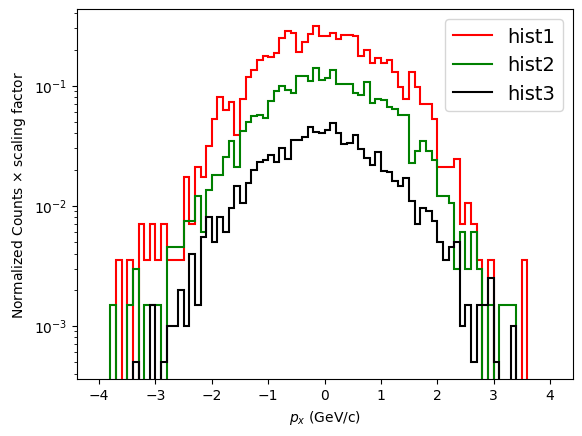

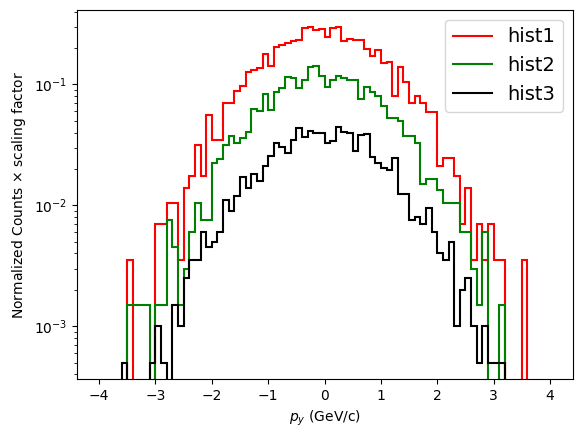

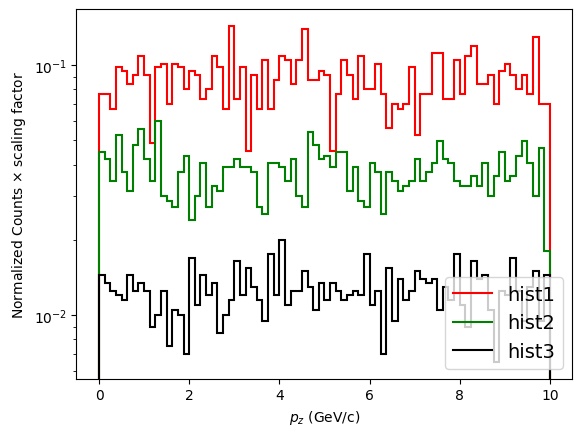

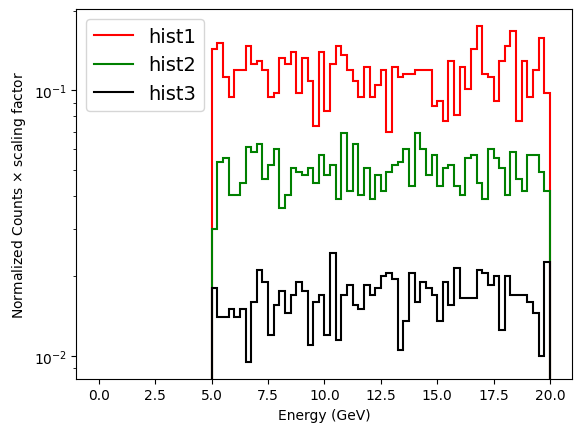

In [243]:
xlabels = [
    "$p_{x}$ (GeV/c)",
    "$p_{y}$ (GeV/c)",
    "$p_{z}$ (GeV/c)",
    "Energy (GeV)",
]

variables = ["px", "py", "pz", "pt", "Energy"]

for variable, xlabel_, histograms in zip(variables, xlabels, filled_hists_lists):
    hist1 = histograms[0][0]
    hist2 = histograms[1][0]
    hist3 = histograms[2][0]
    plot_histograms(hist1, hist2, hist3, xlabel_, log_y=True)
    plt.show()